In [32]:
import numpy as np
import pandas as pd
from collections import namedtuple

In [2]:
i = pd.read_excel('I.xlsx')
rb = pd.read_excel('./RB(main).xlsx')

In [10]:
i_tr = i.head(1000).copy()
rb_tr = rb.head(1000).copy()

In [11]:
def rsi(price, period=28):
    diff = price.diff().dropna()
    rs = (diff>0).rolling(period, min_periods=1).mean() / (diff<0).rolling(period, min_periods=1).mean()
    rsi = lambda rs : 100*(1 - 1 / (1+rs))
    return rsi(rs).dropna().reindex_like(price, method='pad')

In [12]:
def preproc(data, period=28):
    data.index = pd.to_datetime(data.date)
    data['rsi_1m'] = rsi(data.open, period=period)
    data['rsi_1h'] = rsi(data.open.resample('1h').mean().reindex_like(data.open, 'pad'), period=period)
    return data.dropna()

In [13]:
i_tr = preproc(i_tr)
rb_tr = preproc(rb_tr)

<AxesSubplot:xlabel='date'>

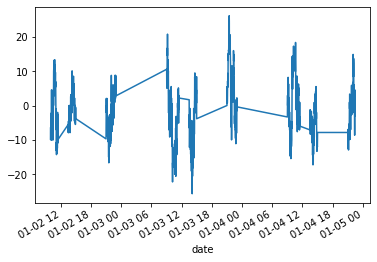

In [15]:
(i_tr.rsi_1m - rb_tr.rsi_1m).dropna().plot()

In [93]:
class Strategy:
    
    def __init__(self, params=None):
        self._params = params
        self.cash = 0
        self.amounts = np.array([0.,0.])
            
    
    def step(self, state):
        if self._buy_cond(state):
            self.amounts += np.array([1.3, -1])
            self.cash += -state.instrument_1*1.3 + state.instrument_2
        if self._sell_cond(state):
            self.amounts += np.array([-1.3, +1])
            self.cash += state.instrument_1*1.3 - state.instrument_2
        
    def _buy_cond(self, state):
        return state.big_bias > 0 and state.big_bias > self._params['min_thr']  \
                and state.big_bias < self._params['max_thr'] and state.small_bias > self._params['min_thr']
    
    def _sell_cond(self, state):
        min_thr = self._params['min_thr']
        max_thr = self._params['max_thr']
        return state.big_bias<0 and abs(state.big_bias) > min_thr and abs(state.big_bias)< max_thr and \
                state.small_bias<max_thr and abs(state.small_bias) > min_thr
    
    def finalize(self, state):
        self.cash += self.amounts[0]*state.instrument_1 + self.amounts[1]*state.instrument_2
        return self.cash
    
    def get_params(self):
        return list(self._params.values())
    
    def set_params(self, values):
        for k, v in zip(self._params.keys(), values):
            self._params[k] = v
            
            
    def rollout(self, data):
        self.reset()
        last_state = None
        for state in df.itertuples():
            last_state = state
            self.step(state)
        return self.finalize(last_state)
    
    
    def reset(self):
        self.cash = 0
        self.amounts = np.array([0.,0.]).astype(float)
    
        

In [100]:
def compound_df(i1, i2):
    df = pd.DataFrame()
    df['instrument_1'] = i1.open
    df['instrument_2'] = i2.open
    df['big_bias'] = i1.rsi_1h - i2.rsi_1h
    df['small_bias'] = i1.rsi_1m - i2.rsi_1m
    return df

In [101]:
df = compound_df(i_tr, rb_tr)

In [102]:
from scipy.optimize import differential_evolution

In [103]:
df = compound_df(i_tr, rb_tr)
def load_and_run(x):
    s = Strategy({'min_thr': 7, 'max_thr': 200})
    s.set_params(x)
    return s.rollout(df)

In [106]:
differential_evolution(load_and_run, bounds=[(0,200), (0,200)])

     fun: -753.1999999998661
 message: 'Optimization terminated successfully.'
    nfev: 693
     nit: 22
 success: True
       x: array([  0.88512673, 106.79910996])